###Теперь решаем задачу регрессии - предскажем цены на недвижимость. Использовать датасет https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data (train.csv)
*Данных немного, поэтому необходимо использовать 10-fold кросс-валидацию для оценки качества моделей
Построить случайный лес, вывести важность признаков
Обучить стекинг как минимум 3х моделей, использовать хотя бы 1 линейную модель и 1 нелинейную
Для валидации модели 2-го уровня использовать отдельный hold-out датасет, как на занятии
Показать, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out)
В качестве решения: Jupyter notebook с кодом, комментариями и графиками, ссылка на гитхаб*

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import auc, roc_curve, roc_auc_score, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('train.csv')
print(data.shape)
data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#Находим категориальные признаки
cat_feat = list(data.dtypes[data.dtypes == object].index)
print('Категориальные признаки \n',cat_feat)

#закодируем пропущенные значений строкой, факт пропущенного значения тоже может нести в себе информацию
data[cat_feat] = data[cat_feat].fillna('nan')

#отфильтруем непрерывные признаки
num_feat = [f for f in data if f not in (cat_feat + ['Id', 'SalePrice'])]
print('Непрерывные признаки \n', num_feat)

# Смотрим сколько у нас значений по каждому категориальному признаку
cat_nunique = data[cat_feat].nunique()
print(cat_nunique)

#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 30 уникальных значений
cat_feat = list(cat_nunique[cat_nunique < 30].index)

Категориальные признаки 
 ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
Непрерывные признаки 
 ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', '

In [4]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(data[cat_feat], columns=cat_feat)

dummy_cols = list(set(dummy_train))

dummy_train = dummy_train[dummy_cols]

# Заменяем пропуски на специальное значение -999, чтобы деревья могли их отличить
X = pd.concat([data[num_feat].fillna(-999),
                     dummy_train], axis=1)

# Подготовим отдельные данные для линейной и логистической регрессии
from sklearn.preprocessing import StandardScaler

train_median = data[num_feat].median()

X_lin = pd.concat([data[num_feat].fillna(train_median),
                     data[num_feat + cat_feat].isnull().astype(np.int8).add_suffix('_NaN'),
                     dummy_train], axis=1)

scaler = StandardScaler()
scaler.fit(X_lin[num_feat])

X_lin[num_feat] = scaler.transform(X_lin[num_feat])

y = data['SalePrice']
print(X.shape)
X.head()

(1460, 304)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Condition2_Feedr,Utilities_NoSeWa,BldgType_1Fam,Foundation_Stone,PoolQC_nan,Utilities_AllPub,Condition1_Artery,Exterior1st_CemntBd,SaleType_COD,Electrical_Mix
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,1,0,1,1,0,0,0,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,1,0,1,1,0,0,0,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,1,0,1,1,0,0,0,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,1,0,1,1,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,1,0,1,1,0,0,0,0


In [5]:
print(X_lin.shape)
X_lin.head()

(1460, 383)


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Condition2_Feedr,Utilities_NoSeWa,BldgType_1Fam,Foundation_Stone,PoolQC_nan,Utilities_AllPub,Condition1_Artery,Exterior1st_CemntBd,SaleType_COD,Electrical_Mix
0,0.073375,-0.220875,-0.207142,0.651479,-0.517200,1.050994,0.878668,0.514104,0.575425,-0.288653,...,0,0,1,0,1,1,0,0,0,0
1,-0.872563,0.460320,-0.091886,-0.071836,2.179628,0.156734,-0.429577,-0.570750,1.171992,-0.288653,...,0,0,1,0,1,1,0,0,0,0
2,0.073375,-0.084636,0.073480,0.651479,-0.517200,0.984752,0.830215,0.325915,0.092907,-0.288653,...,0,0,1,0,1,1,0,0,0,0
3,0.309859,-0.447940,-0.096897,0.651479,-0.517200,-1.863632,-0.720298,-0.570750,-0.499274,-0.288653,...,0,0,1,0,1,1,0,0,0,0
4,0.073375,0.641972,0.375148,1.374795,-0.517200,0.951632,0.733308,1.366489,0.463568,-0.288653,...,0,0,1,0,1,1,0,0,0,0


### Выделим из дата сета 20% для теста

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
# Разбиваем на train/test
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=777)

for train_index, test_index in splitter.split(X, np.zeros(X.shape[0])):
    X_train = X.iloc[train_index]
    X_test = X.iloc[test_index]
    X_lin_train = X_lin.iloc[train_index]
    X_lin_test = X_lin.iloc[test_index]
    
    
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]


### Функция для кросс валидации

In [7]:
def crossValidation(model, X, y, N = 10):
  kf = KFold(n_splits=N, shuffle=True)
  print(cross_val_score(model, X, y, cv=kf).mean())

### Обучим случайный лес И выведем важность признаков

In [8]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=10, max_depth=5, min_samples_leaf=20, max_features=0.5, n_jobs=-1)
clf_rf.fit(X_train, y_train)
crossValidation(clf_rf, X_train, y_train) 

0.009401709401709401


In [9]:
imp = pd.Series(clf_rf.feature_importances_)
imp.sort_values(ascending=False)

15     0.086388
2      0.082304
8      0.056680
27     0.052834
26     0.048233
11     0.046878
3      0.045941
24     0.044384
12     0.034125
28     0.026594
10     0.022657
25     0.022066
5      0.020502
1      0.018765
209    0.017879
183    0.016817
158    0.016298
23     0.015865
18     0.015813
6      0.015805
42     0.015676
41     0.015519
35     0.015279
234    0.012873
20     0.011641
29     0.011562
125    0.011282
267    0.010927
85     0.010201
98     0.009786
         ...   
213    0.000000
214    0.000000
215    0.000000
216    0.000000
217    0.000000
218    0.000000
219    0.000000
220    0.000000
221    0.000000
222    0.000000
223    0.000000
207    0.000000
206    0.000000
205    0.000000
194    0.000000
188    0.000000
189    0.000000
190    0.000000
191    0.000000
192    0.000000
193    0.000000
195    0.000000
203    0.000000
196    0.000000
197    0.000000
198    0.000000
199    0.000000
201    0.000000
202    0.000000
151    0.000000
Length: 304, dtype: floa

### Обучим логистическую регрессию

In [10]:
from sklearn.linear_model import LogisticRegression
clf_lr = LogisticRegression()
clf_lr.fit(X_lin_train, y_train)
crossValidation(clf_lr, X_lin_train, y_train)

0.012849985263778368


### Обучим линейную регрессию RidgeCV

In [11]:
from sklearn.linear_model import RidgeCV
clf_ll = RidgeCV()
clf_ll.fit(X_lin_train, y_train)
crossValidation(clf_ll, X_lin_train, y_train)


0.788329064829038


### Функции стекинга и графика ROC

In [12]:
def show_auc(y, y_pred, plot_label='', prin=True):    
    auc_val = 1 - mean_squared_error(y, y_pred, squared=False)/ np.mean(y)
    print('Процент точности предсказания по средней квадратичной ошибке в моделе {0:} : {1:.4f}'.format(plot_label,auc_val))
    

In [13]:
def get_meta_features(clf, X_train, y_train, X_test, stack_cv):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros_like(y_test, dtype=float)
    
    for i, (train_ind, test_ind) in enumerate(stack_cv.split(X_train, y_train)):
        
        clf.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = clf.predict(X_train.iloc[test_ind])
        meta_test += clf.predict(X_test)
    
    return meta_train, meta_test / stack_cv.n_splits

### Стекинг

In [14]:
from sklearn.model_selection import StratifiedKFold

stack_cv = StratifiedKFold(n_splits=10, random_state=555)

meta_train = []
meta_test = []
col_names = []

print('LR features...')
meta_tr, meta_te = get_meta_features(clf_lr, X_lin_train, y_train, X_lin_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('lr_pred')

print('LL features...')
meta_tr, meta_te = get_meta_features(clf_ll, X_lin_train, y_train, X_lin_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('ll_pred')

print('RF features...')
meta_tr, meta_te = get_meta_features(clf_rf, X_train, y_train, X_test, stack_cv)

meta_train.append(meta_tr)
meta_test.append(meta_te)
col_names.append('rf_pred')

LR features...
LL features...
RF features...


In [15]:
X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)
from sklearn.ensemble import RandomForestRegressor

clf_lr_meta = RandomForestRegressor()
clf_lr_meta.fit(X_meta_train, y_train)
y_pred_meta_test = clf_lr_meta.predict(X_meta_test)

show_auc(y_test, y_pred_meta_test, 'stack')


Процент точности предсказания по средней квадратичной ошибке в моделе stack : 0.8326


### Сравним точность предсказания Stack модели и каждой модели по отдельности - все предсказания получились менее точными

In [16]:
y_pred = clf_ll.predict(X_lin_test)
show_auc(y_test, y_pred, 'RidgeCV')

Процент точности предсказания по средней квадратичной ошибке в моделе RidgeCV : 0.8172


In [17]:
y_pred = clf_lr.predict(X_lin_test)
show_auc(y_test, y_pred, 'LogisticRegression')

Процент точности предсказания по средней квадратичной ошибке в моделе LogisticRegression : 0.7132


In [18]:
y_pred = clf_rf.predict(X_test)
show_auc(y_test, y_pred, 'RandomForest')

Процент точности предсказания по средней квадратичной ошибке в моделе RandomForest : 0.6865


### посмотрим вклад каждой модели в Стеке
самый большой вклад дает RidgeCV

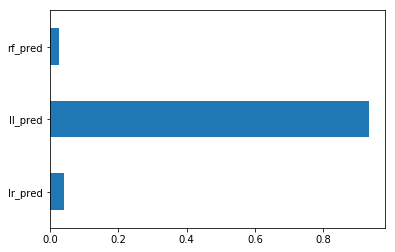

In [19]:
pd.Series(clf_lr_meta.feature_importances_.flatten(), index=X_meta_train.columns).plot(kind='barh')